In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

####Generate a mixing matrix for use in metapopulation code###
* Size will be npatchxnpatch
* Dispersion kernel defined by:  
$ p(d) = \frac{1}{N} \exp\left(-(d/\alpha)^c\right)$  
$\alpha$ sets the length scale of dispersion, and $c$ adjusts the 'tail fatness.' Higher $c$ means fatter (skinnier??) tails. $d$ is the distance between the points.
* Normalization constant is:  
$N = \frac{2\pi \alpha^2 \Gamma(2/c)}{c}$


In [2]:
#Set constants for the matrix you want.
n = 20         #size of an edge (even numbers make the movie easier)
npatch = n*n   #npatch is nxn - the matrix is npatchxnpatch
alpha = 1.     #length scale
cinj = 0.5        #tail weight (lower c -> higher tail weight)

In [3]:
def distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
def kernel(d,a,c):
    N = 2.*np.pi*a*sp.special.gamma(1./c)/c
    pofd = np.exp(-((d/a)**c))
    return pofd/N

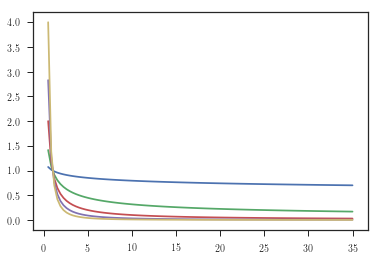

In [270]:
dist = np.linspace(0.5,35,100) #For normalization purposes, should neighboring cells be 'zero'? (Yes.)
dx = dist[1]-dist[0]

ctest = [0.1,0.5,1.,1.5,2.]
alpha = 5.
for cinj in ctest:
    k = kernel(dist,alpha,cinj)
    k = 1./(dist**cinj)
    #k /= sum(k*dx)   #Normalize
    plt.plot(dist,k)
    #plt.ylim(0,0.4)

In [11]:
dist = np.abs(np.sqrt((20-19)**2+(20-19)**2)) #scaled by a bit
print dist

1.41421356237


In [264]:
#For a given alpha and c, you want to output an npatchxnpatch matrix with k giving the values of each cell. 
#You should only have to calculate k once - it just gets 'shifted' for each new row. The trick is to calculate 
#the distance between each point in the row. If i=j, this kernel should be the non-mixed value. Say 0.1, whatever. It's
#going to get scaled anyway.
cinj = 1.2
alpha = 10.
mixmat = np.zeros([n,n])
mixmat += 0.00001
betamat = []
for istar in range(n):
    for jstar in range(n):
        for i in range(n):
            for j in range(n):
                dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2))+0.5 #scaled by a bit so that min distance isn't 1.0
                if dist<=0:
                    dist = 0.05
                if (i==istar)&(j==jstar):
                    dist = 0.05
                k = kernel(dist,alpha,cinj)
                k = 1./dist**0.1
                mixmat[i,j] = k
                
                #To generate a diagonal mixing matrix:   
                '''
                mixmat[i,j] = 0.
                '''
        #for diagonal:        
        #mixmat[istar,jstar] = 1.
        #The way we're going to code it up now, [istar,jstar] should always be zero - even when using a 'diagonal'
        #mixing matrix, becuase now the within-patch dynamics are completely separate.
        mixmat[istar,jstar] = 0.
        
        mixvec = mixmat.flatten()
        betamat.append(mixvec)
betamat = np.array(betamat)

In [265]:
#Need to scale so that the population mixing isn't explicitly affecting R0. Set maximum eigenvalue to 1.0.
R0 = 1.
gamma = 1.                  #Number of timesteps to recovery. Our timesteps are two weeks long, so this is just one.
maxeig = R0*gamma

for i in range(n*n):
    trial = betamat[i,:].copy()                       #mixing matrix associated with individual cell
    trial = trial.reshape(n,n)
    scale = np.real(np.max(np.linalg.eigvals(trial)))
    betamat[i,:] *= 1./scale                          #Scale so the maximum eigenvalue *of each matrix* is 1.0

print scale
trial = betamat[209,:].copy()                 #check that this worked.
trial = trial.reshape(n,n)
print np.max(np.linalg.eigvals(trial)) 

15.3800099398
(1+0j)


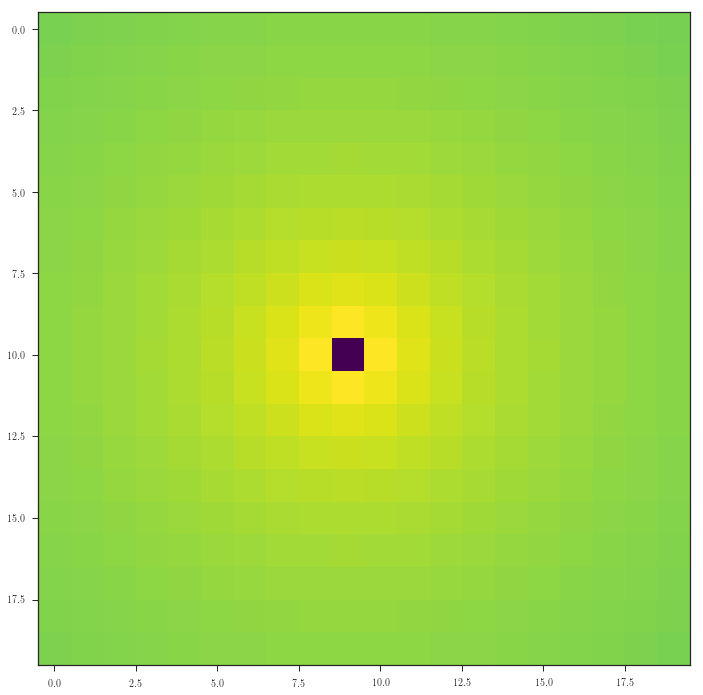

In [266]:
plt.figure(figsize=(12,12))
plt.imshow(trial,cmap='viridis',interpolation='none')

In [92]:
'''
filename = 'mixingMatrices/Diagonal.hpp'
with open(filename,"w") as f:
    f.write("static std::array<std::array<float, nptch>, nptch> sbetaMatrix = {{\n")
    for row in betamat:
        f.write("{{")
        for i in range(npatch-1):
            f.write(str(row[i])+",")
        f.write(str(row[npatch-1])+"}},\n")
    f.write("}};")
    '''

'\nfilename = \'mixingMatrices/Diagonal.hpp\'\nwith open(filename,"w") as f:\n    f.write("static std::array<std::array<float, nptch>, nptch> sbetaMatrix = {{\n")\n    for row in betamat:\n        f.write("{{")\n        for i in range(npatch-1):\n            f.write(str(row[i])+",")\n        f.write(str(row[npatch-1])+"}},\n")\n    f.write("}};")\n    '

In [135]:
popmat = np.ones([n,n])*np.abs(np.random.normal(loc=2,scale=2,size=[n,n]))
rate = sum(sum(trial*popmat))/(n*n)
print rate
draws = np.random.poisson(rate,size=200)
print np.mean (draws)

0.102520464305
0.145


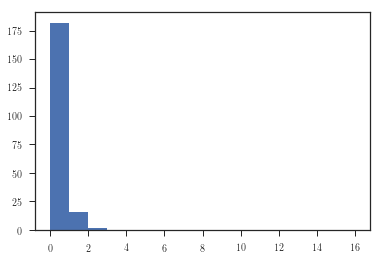

In [94]:
a,b,c = plt.hist(draws,bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])


In [243]:
cinj = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
cinj = np.logspace(np.log10(0.1),np.log10(5.),num=10)
popmat = np.ones([n,n])*np.abs(np.random.normal(loc=25,scale=2,size=[n,n]))
rates2 = []
for c in cinj:
    mixmat = np.zeros([n,n])
    mixmat += 0.00001
    betamat = []
    for istar in range(n):
        for jstar in range(n):
            for i in range(n):
                for j in range(n):
                    dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2)) #scaled by a bit
                    if dist==0:
                        dist = 1.
                    mixmat[i,j] = 1./dist**c
            mixmat[istar,jstar] = 0.  
    rate = sum(sum(mixmat*popmat))/(n*n)
    draws = np.random.poisson(rate,size=200)
    rates2.append([c,rate,np.mean(draws)])
rates2 = np.array(rates2)

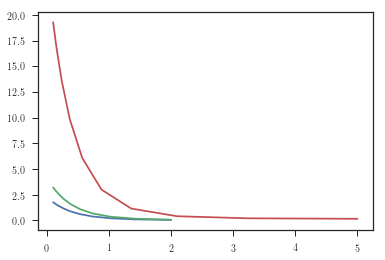

In [244]:
plt.plot(rates0[:,0],(rates0[:,1]))
plt.plot(rates1[:,0],(rates1[:,1]))
plt.plot(rates2[:,0],(rates2[:,1]))

In [246]:
istar = 10
jstar = 10
i = 10
j = 9
dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2))+0.5 #scaled by a bit
print dist

1.5
